In [ ]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')


# Analysis of the measurements of device TD1606 in Orsey

In [1]:
## FMcMillen model functions

import numpy
import matplotlib.pyplot as plt
from cmath import sqrt
import time 
from lmfit import Parameters, minimize, fit_report
import scipy.io
from scipy.interpolate import interp1d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter



%matplotlib inline



def FermiDirac(E,T):
    return numpy.array(1 / (1 + numpy.exp(E / T)))

def SelfConsEq(Delta,E,Delta0,Gamma):
    if Delta[0].imag > 0:
        Delta[0] = Delta[0].conjugate()
    if Delta[1].imag > 0:
        Delta[1] = Delta[1].conjugate()

    NewDelta = numpy.ndarray(2,complex)
    NewDelta[0] = (Delta0[0] + Gamma[0] * Delta[1] / sqrt(Delta[1]**2 - E**2))/ \
         (1  + Gamma[0] / sqrt(Delta[1] ** 2 - E ** 2))
    NewDelta[1] = (Delta0[1] + Gamma[1] * Delta[0] / sqrt(Delta[0]**2 - E**2))/ \
         (1  + Gamma[1] / sqrt(Delta[0] ** 2 - E ** 2))

    return NewDelta

def Iterations(prevDelta,E,Delta0,Gamma):
    errors = numpy.array([1,1])
    index = 0
    prevDelta = prevDelta + 0.1*1j
    while (max(abs(errors))> 1e-6 ) and (index < 1e1):
        index = index+1
        newDelta = SelfConsEq(prevDelta,E,Delta0,Gamma)
        errors = prevDelta - newDelta
        prevDelta = newDelta
    return newDelta, errors

def CalculateDOS(Energys,Delta0,Gamma,Neff,alpha = 0):
    
    Neff = numpy.array(Neff)
    Gamma = numpy.array(Gamma)
    Delta0 = numpy.array(Delta0)
    Energys = numpy.array(Energys)
    
    initDelta = numpy.array([0.5-0.1*1j, 0 + 0.1*1j])
    sol , err = Iterations(initDelta,0,Delta0,Gamma)
    
    Ns = [0]*(len(Energys))
    Deltas = [0]*(len(Energys))
    errors = [0]*(len(Energys))
    N = numpy.ndarray(len(Energys))
    
    for k in range(len(Energys)):
        initDelta = sol
        sol , err = Iterations(initDelta,Energys[k],Delta0,Gamma)
        Deltas[k] = sol
        errors[k] = err
        u = Energys[k] / sol
        if alpha ==0:
            Ns[k] = Neff * (u/(u**2 - 1 )**0.5).real
        else:
            Ns[k] = Neff * AG_DOS(Energys[k],sol,alpha)
        N[k] = sum(Ns[k])
   
    return N

def IofV(Vs,Delta0,Gamma,Neff,T,alpha = 0):
    energys = numpy.linspace(0,6,1000)
    N = CalculateDOS(energys,Delta0,Gamma,Neff,alpha)
    
    energys = numpy.concatenate([numpy.flipud(-energys),energys])
    N = numpy.concatenate([numpy.flipud(N),N])
    N = N/N[0]
    

    Is = numpy.ndarray(len(Vs))


    FDS = FermiDirac(energys,T)
    for k in range(len(Vs)):
        FDN = FermiDirac(energys-Vs[k],T)
        Is[k] = sum(N * (FDN - FDS))
    
    slope = (sum(FermiDirac(energys-Vs[len(Vs)-1],T) - FDS) - sum(FermiDirac(energys-Vs[0],T) - FDS))/(Vs[len(Vs)-1]- Vs[0])
    
    return Is/slope


In [2]:
def AG_DOS(E,Delta,alpha):
    
    xi = E/Delta * (1 + 0j)
    alpha = numpy.ones(len(Delta))* alpha * (1 + 0j)
    
    A = 2 - 2 * alpha**2 + xi**2
    B = (-1 + alpha**2 + xi**2)**2
    C = -1 + alpha**6 + 3 * xi**2  - 3 * xi**4 +xi**6 \
        + 3 * alpha**4 * (-1 + xi**2) +3 * alpha**2 * (1 + 16 * xi**2 + xi**4)
    D = 6 * numpy.sqrt(3) * numpy.sqrt(alpha**2 * xi**2 * (alpha**6 + 3 * alpha**4 * (-1 + xi**2)+(-1 + xi**2)**3 \
        + 3 * alpha**2 * ( 1 + 7 * xi**2 + xi**4)))
    E = (C+ D) ** (1 / 3.0)
    
    u = 1/6 * ( 3 * xi + sqrt(3) * numpy.sqrt((A + B/E + E)) - sqrt(3) * numpy.sqrt(2 * A -  B / E - E \
        - 6 * sqrt(3) * (1 + alpha**2) * xi / numpy.sqrt(A + B / E + E  ) ))

    return (u / numpy.sqrt(u**2 - 1)).real

In [43]:
## Data manipulation and fit functions


def LoadandSymmetrizeTemp(index,shift):
    bigdata = scipy.io.loadmat('summary-data.mat')
    tempdata = bigdata['Temperature']    
#     required data
    data = numpy.array(tempdata[0][index-1][1][0][0][0]).transpose()
    V = data[1]
    G = data[2]
 
    return symmetrize(V,G,shift)

def LoadandSymmetrizePerField(index,shift):
    bigdata = scipy.io.loadmat('summary-data.mat')
    PerpFieldData = bigdata['PerpField']
    data = numpy.array(PerpFieldData[0][index-1][0]).transpose()
    V = data[1]
    G = data[2]
    B = 4*(15-(index-1)/3)
 
    return symmetrize(V,G,shift)

def LoadandSymmetrizeParField(index,shift, sym = True):
    bigdata = scipy.io.loadmat('summary-data.mat')
    PerpFieldData = bigdata['ParFieldwComp']
    data = numpy.array(PerpFieldData[0][index-1][0]).transpose()
    V = data[1]
    G = data[2]
    B = bigdata['ParFieldwComp'][0][index-1][1][0][0]
    if sym:
        V, G, Gasym = symmetrize(V,G,shift)
    else:
        Gasym = V*0
    return V, G, Gasym ,B
        


def symmetrize(V,G,shift):
    bigdata = scipy.io.loadmat('summary-data.mat')
    tempdata = bigdata['Temperature']
    
#     high temp data
    data = numpy.array(tempdata[0][9][1][0][0][0]).transpose()
    Vhigh = data[1]
    Ghigh = data[2]
    
#     dividing the low T by the High T
    GhighI = interp1d(Vhigh,Ghigh)(V)
    Gnew = G / GhighI

#     shifting the voltgae to correct for zero drift
    V = V + shift

    Gflip = interp1d(V,numpy.flipud(Gnew))(V)
    Gsym = (Gnew+Gflip)/2;
    Gasym = (Gnew-Gflip)/2;
 
    return V,Gsym,Gasym    


# build 3D data arrays for parallel field:
def LoadAllParField(shift,sym = True):
#     returns Vs, Bs, Gs, Vsm1, Bsm1, dGdVs, ParB
    k = 1
    Vs, Gs, Gasym,B = LoadandSymmetrizeParField(1,shift,sym)
    V = Vs
    Vsm1 = V[0:len(V)-1]
    G = Gs
    dGdVs = numpy.diff(G)/numpy.diff(V)
    Bs = numpy.ones(len(V))*B
    Bsm1 = numpy.ones(len(V)-1)*B
    for k in range(2,35):
        V, G, Gasym, B = LoadandSymmetrizeParField(k,shift,sym)
        dGdV = numpy.diff(G)/numpy.diff(V)

        Vs = numpy.vstack((Vs, V))
        Vsm1 = numpy.vstack((Vsm1, V[0:len(V)-1]))
        Gs = numpy.vstack((Gs, G))   
        dGdVs = numpy.vstack((dGdVs, dGdV))
        Bs = numpy.vstack((Bs, numpy.ones(len(V))*B))
        Bsm1 = numpy.vstack((Bsm1, numpy.ones(len(V)-1)*B))
    ParB = Bs.transpose()[0]
    
    return Vs, Bs, Gs, Vsm1, Bsm1, dGdVs, ParB


def LoadFitPlot(V,G,params,Vlim,alpha = 0):
        
    Delta0 = [params['Delta01'].value, params['Delta02'].value]
    Gamma = [params['Gamma1'].value, params['Gamma2'].value]
    Neff = [params['Neff1'].value, params['Neff2'].value]
    T = params['T'].value
    
    print(readParameters(params))
    
    Vs = numpy.linspace(min(V),max(V),300)
    I = IofV(Vs,Delta0,Gamma,Neff,T,alpha)
    
    fig = plt.figure(figsize=(8, 8), dpi=80)
    plt.subplot(2, 1, 1)

    plt.plot(V,G,color = 'black',label = 'data',marker = 's',markersize = 2.5,linewidth = 0)
    plt.plot(Vs[0:len(Vs)-1],numpy.diff(I)/numpy.diff(Vs),'r',linewidth=1.5,label = 'fit')
    plt.xlim(Vlim[0], Vlim[1])
    plt.ylim(0,2)
    plt.legend()
    plt.xlabel('V (mV)')
    plt.ylabel('G (a.u.)')

    plt.subplot(2, 1, 2)
    plt.plot(V[1:len(V)],numpy.diff(G)/numpy.diff(V),color = 'black',label = 'data',marker = 's',\
             markersize = 2.5,linewidth = 0)
    plt.plot(Vs[1:len(Vs)-1],numpy.diff(I,2)/(numpy.diff(Vs[1:len(Vs)])**2),'r',linewidth=1.5,label = 'fit')
    plt.xlim(Vlim[0], Vlim[1])
    plt.legend()
    plt.xlabel('V (mV)')
    plt.ylabel('dG/dV (a.u.)')

    plt.show()
    
    return fig

def Goodness(params,V,G,Gerr,Vlim):
    
    Delta0 = [params['Delta01'].value, params['Delta02'].value]
    Gamma = [params['Gamma1'].value, params['Gamma2'].value]
    Neff = [params['Neff1'].value, params['Neff2'].value]
    T = params['T'].value
    
    Vfit = numpy.linspace(-6,6,500)
    I = IofV(Vfit,Delta0,Gamma,Neff,T)
    Gfit = numpy.diff(I)/numpy.diff(Vfit)

#  trimming:
    Vmin = Vlim[0]
    Vmax = Vlim[1]
    MinIndex = numpy.argmin(abs(V-Vmin))
    MaxIndex = numpy.argmin(abs(V-Vmax))
    V = V[MinIndex:MaxIndex]
    G = G[MinIndex:MaxIndex]
    Gerr = Gerr[MinIndex:MaxIndex]

    GforChi = interp1d(Vfit[1:len(Vfit)],Gfit)(V)
    
    return (GforChi-G)/Gerr

def Goodness2(params,V,G,Gerr,Vlim):
    
    Delta0 = [params['Delta01'].value, params['Delta02'].value]
    Gamma = [params['Gamma1'].value, params['Gamma2'].value]
    Neff = [params['Neff1'].value, params['Neff2'].value]
    T = params['T'].value
    
    Vfit = numpy.linspace(-6,6,500)
    I = IofV(Vfit,Delta0,Gamma,Neff,T)
    Gfit = numpy.diff(I)/numpy.diff(Vfit)

#  trimming:
    Vmin = Vlim[0]
    Vmax = Vlim[1]
    MinIndex = numpy.argmin(abs(V-Vmin))
    MaxIndex = numpy.argmin(abs(V-Vmax))
    V = V[MinIndex:MaxIndex]
    G = G[MinIndex:MaxIndex]
    Gerr = Gerr[MinIndex:MaxIndex]

    GforChi = interp1d(Vfit[1:len(Vfit)],Gfit)(V)
    
    
    return (numpy.diff(GforChi)-numpy.diff(G))/Gerr[1:len(G)]

def VortexFit(Vparams,V,G,Gerr,Vlim):
    a = Vparams['a'].value
    b = Vparams['b'].value
    c = Vparams['c'].value    
    V0 = Vparams['V0'].value
    
    Vmin = Vlim[0]
    Vmax = Vlim[1]
    MinIndex = numpy.argmin(abs(V-Vmin))
    MaxIndex = numpy.argmin(abs(V-Vmax))
    V = V[MinIndex:MaxIndex]
    G = G[MinIndex:MaxIndex]
    Gerr = Gerr[MinIndex:MaxIndex]
    
    Gfit = a*(V-V0)**2+b*abs((V-V0))+c

    return (Gfit-G)/Gerr

def GiveGs(V,Vparams):
    a = Vparams[0]
    b = Vparams[1]
    c = Vparams[2]
    V0 = Vparams[3]
    return (a*(V-V0)**2+b*abs((V-V0))+c).transpose()

In [4]:
## Assisting functions for using the lmfit package

def makeParamaters(dataline):
    params = Parameters()
    params.add('Delta01', value=dataline[0], min = 0.0, vary = True)
    params.add('Delta02', value=dataline[1], min = 0.0, vary = True)
    params.add('Gamma1', value=dataline[2], min = 0.0, vary = True)
    params.add('Gamma2', value=dataline[3], min = 0.0, vary = True)
    params.add('Neff1', value=dataline[4], vary = False)
    params.add('Neff2', value=dataline[5], min = 0.0, vary = True)
    params.add('T', value=dataline[6], min = 0.0, vary = True)
    return params

def readParameters(params):
    dataline = numpy.ndarray(7)
    dataline[0] = params['Delta01'].value
    dataline[1] = params['Delta02'].value
    dataline[2] = params['Gamma1'].value
    dataline[3] = params['Gamma2'].value
    dataline[4] = params['Neff1'].value
    dataline[5] = params['Neff2'].value
    dataline[6] = params['T'].value
    return dataline
    
def makeVParamaters(dataline):
    params = Parameters()
    params.add('a', value=dataline[0], min = 0.0, vary = False)
    params.add('b', value=dataline[1], min = 0.0, vary = True)
    params.add('c', value=dataline[2], min = 0.0, vary = True)    
    params.add('V0', value=dataline[3], vary = True)
    return params

def readVParameters(params):
    dataline = numpy.ndarray(4)
    dataline[0] = params['a'].value
    dataline[1] = params['b'].value
    dataline[2] = params['c'].value
    dataline[3] = params['V0'].value
    return dataline

   

In [34]:
# update / save data files

AllData = {}

AllData['TempData'] = Tempdata
AllData['TempDataRaw'] = TempdataRaw
AllData['Tsample'] = Tsample
AllData['FitNoDelta2'] = FitNoDelta2
AllData['FitNoDelta2Raw'] = FitNoDelta2Raw
AllData['FitFixedT200mK'] = FitFixedT200mK
AllData['FitFixedT200mKRaw'] = FitFixedT200mKRaw


AllData['PerFieldData'] = PerFieldData
AllData['PerFieldDataRaw'] = PerFielddataRaw
AllData['PerFieldLinFit_0p1'] = PerFieldLinFit_0p1
AllData['PerFieldLinFit_0p2'] = PerFieldLinFit_0p2
AllData['PerFieldLinFit_0p3'] = PerFieldLinFit_0p3
AllData['PerB'] = PerB
AllData['PerFieldDataFreeDeltas'] = PerFieldDataFreeDeltas
AllData['PerFielddataFreeDeltasRaw'] = PerFielddataFreeDeltasRaw
AllData['PerFieldDataFixedGammas'] = PerFieldDataFixedGammas
AllData['PerFielddataFixedGammasRaw'] = PerFielddataFixedGammasRaw


AllData['ParB'] = ParB
AllData['ParFieldLinFit_0p1'] = ParFieldLinFit_0p1
AllData['ParFieldLinFit_0p2'] = ParFieldLinFit_0p2
AllData['ParFieldLinFit_0p3'] = ParFieldLinFit_0p3

# numpy.save('AnalysisData',AllData)

In [5]:
# Load data from file

AllData = numpy.load('AnalysisData.npy')

Tempdata = AllData[()]['TempData']
TempdataRaw = AllData[()]['TempDataRaw']
Tsample = AllData[()]['Tsample']
FitNoDelta2 = AllData[()]['FitNoDelta2']
FitNoDelta2Raw = AllData[()]['FitNoDelta2Raw']
FitFixedT200mK = AllData[()]['FitFixedT200mK'] 
FitFixedT200mKRaw  = AllData[()]['FitFixedT200mKRaw']  



PerFieldData = AllData[()]['PerFieldData']
PerFielddataRaw = AllData[()]['PerFieldDataRaw']
PerFieldLinFit_0p1 = AllData[()]['PerFieldLinFit_0p1']
PerFieldLinFit_0p2 = AllData[()]['PerFieldLinFit_0p2']
PerFieldLinFit_0p3 = AllData[()]['PerFieldLinFit_0p3']
PerFieldDataFreeDeltas = AllData[()]['PerFieldDataFreeDeltas']
PerFielddataFreeDeltasRaw = AllData[()]['PerFielddataFreeDeltasRaw']
PerFieldDataFixedGammas = AllData[()]['PerFieldDataFixedGammas'] 
PerFielddataFixedGammasRaw = AllData[()]['PerFielddataFixedGammasRaw']
PerB = AllData[()]['PerB']

ParB = AllData[()]['ParB']
ParFieldLinFit_0p1 = AllData[()]['ParFieldLinFit_0p1']
ParFieldLinFit_0p2 = AllData[()]['ParFieldLinFit_0p2']
ParFieldLinFit_0p3 = AllData[()]['ParFieldLinFit_0p3']




## Fit of the temperature dependence

The raw is data is shifted to correct for zero drift and symmetrized by flipping it and summing the original and flipped data. The difference between the flipped and the unflipped data is taken as part of the error. The other part is the intrinsic measurment error.
The fit of the temperature dependence is done in two steps: first fit the 70mK data with all the parameters free. Then fit the other temperatures when keeping $\Gamma_{12}$, $\Gamma_{21}$ and $n_2$ fixed.

Below are shown all of the fit for temperature.

In [111]:
# fit temperatures

V, G, Gasym = LoadandSymmetrizeTemp(1,0.12)
Gerr = abs(Gasym)+0.02
params = makeParamaters([1.24,0.4,0.4,1.24,1,0.1,0.04])
start = time.time()
out = minimize(Goodness, params, args=(V, G, Gerr,[-1.5,1.5]))
end = time.time()
Tempdata = readParameters(out.params)
TempdataRaw = [out]

for k in range(2,9):
    params = out.params
    params['Gamma1'].vary = False
    params['Gamma2'].vary = False
    params['Neff2'].vary = False             
    V, G, Gasym = LoadandSymmetrizeTemp(k,0.14)
    Gerr = abs(Gasym)+0.02
    start = time.time()
    out = minimize(Goodness, params, args=(V, G, Gerr,[-1.5,1.5]))
    end = time.time()
    Tempdata = numpy.vstack((Tempdata,readParameters(out.params)))
    TempdataRaw.append(out)
    

KeyboardInterrupt: 

[  3.86969176e-17   1.60782252e+00]


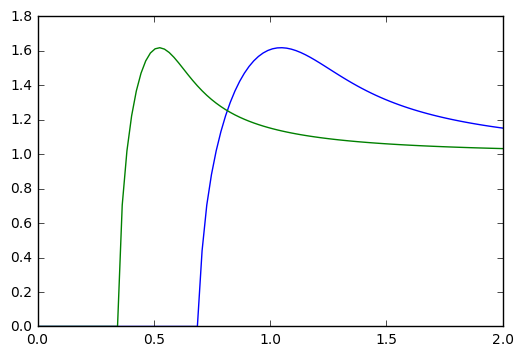

In [44]:
def AG_DOS(E,Delta,alpha):
    E = numpy.array(E)
    Delta = numpy.array(Delta)
    xi = E/Delta * (1 + 0j)
    alpha = numpy.ones(len(Delta))* alpha * (1 + 0j)
    
    A = 2 - 2 * alpha**2 + xi**2
    B = (-1 + alpha**2 + xi**2)**2
    C = -1 + alpha**6 + 3 * xi**2  - 3 * xi**4 +xi**6 \
        + 3 * alpha**4 * (-1 + xi**2) +3 * alpha**2 * (1 + 16 * xi**2 + xi**4)
    D = 6 * numpy.sqrt(3) * numpy.sqrt(alpha**2 * xi**2 * (alpha**6 + 3 * alpha**4 * (-1 + xi**2)+(-1 + xi**2)**3 \
        + 3 * alpha**2 * ( 1 + 7 * xi**2 + xi**4)))
    E = (C+ D) ** (1 / 3.0)
    
    u = 1/6 * ( 3 * xi + sqrt(3) * numpy.sqrt((A + B/E + E)) - sqrt(3) * numpy.sqrt(2 * A -  B / E - E \
        - 6 * sqrt(3) * (1 + alpha**2) * xi / numpy.sqrt(A + B / E + E  ) ))

    return (u / numpy.sqrt(u**2 - 1)).real


Es = numpy.linspace(0,2,100)
Ds = numpy.array([1,0.5])
Ns = AG_DOS(Es[0],Ds,0.1)
for k in range(1,len(Es)):
    Ns = numpy.vstack((Ns,AG_DOS(Es[k],Ds,0.1)))

E = numpy.array([0.5])
Ds = numpy.array([1,1])
print(AG_DOS(0.5,[1,0.5],0.1))
plt.plot(Es,(Ns.transpose())[0])
plt.plot(Es,(Ns.transpose())[1])
plt.show()

[ 1.2337371   0.36352243  0.37875991  1.12460286  1.          0.13332504
  0.0421856 ]


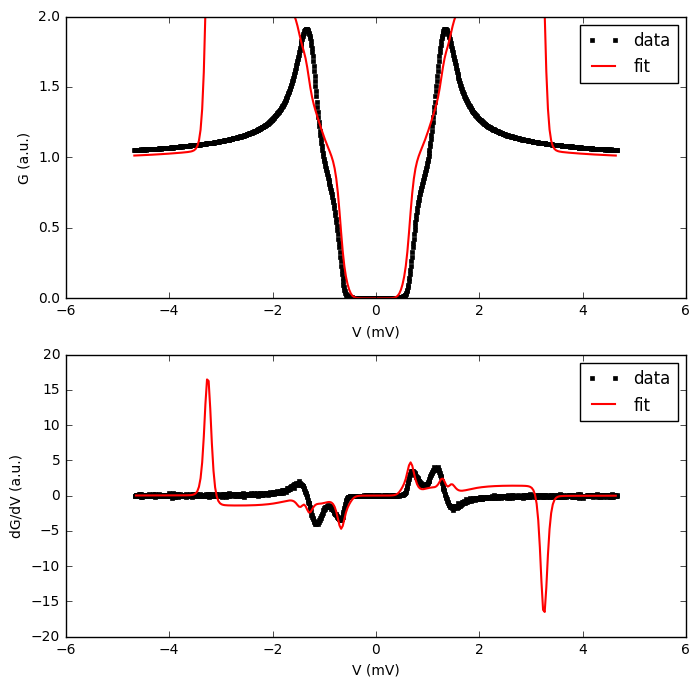

In [45]:
k   =1
V, G, Gasym = LoadandSymmetrizeTemp(k,0.14)
fig = LoadFitPlot(V,G,makeParamaters(Tempdata[k-1]),[-6,6],0.1)


### Compliation of the temperature depndence

Here is some basic complitaion of the previous fits. It seems that the sample temperature is consistent with the cryostat tmeperature above 1K, but below it, it is significantly higher.

In [ ]:
TempdataComp = Tempdata
Tsample = numpy.array([0.07,0.54,0.79,1.25,1.5,1.7,1.9,3.5])
T = TempdataComp.transpose()[6]/0.08
Delta01 = TempdataComp.transpose()[0]
Delta02 = TempdataComp.transpose()[1]

plt.figure(figsize=(6, 7), dpi=80)
plt.subplot(2,1,1)
plt.plot(Tsample,T,color = 'black',label = 'data',marker = 's',\
             markersize = 6,linewidth = 0)
plt.plot([0,4],[0,4],'red',linewidth = 2)
plt.xlabel('$T_{sample}$ (K)')
plt.ylabel('$T_{fit}$ (K)')

plt.subplot(2,1,2)
plt.plot(T,Delta01,label = '$\Delta_L$',marker = 's',\
             markersize = 6,linewidth = 0)
plt.plot(T,Delta02,label = '$\Delta_S$',marker = 's',\
             markersize = 6,linewidth = 0)
plt.xlabel('$T_{fit} $ (K)')
plt.ylabel('$\Delta $ (eV)')
plt.legend()
plt.show()

Now I estimate the error in the fit for the lowest teperature curve:

In [ ]:
print(fit_report(TempdataRaw[0]))

Here I attempt to fit when $\Delta_S = 0$ is fixed. That is assuming that there is only one intrinsic superconducting band. The fit is not as good as with free $\Delta_S$

In [ ]:
V, G, Gasym = LoadandSymmetrizeTemp(1,0.12)
Gerr = abs(Gasym)+0.02
params = makeParamaters([1.24,0.0,0.4,1.24,1,0.1,0.04])
params['Delta02'].vary = False
start = time.time()
out = minimize(Goodness, params, args=(V, G, Gerr,[-1.5,1.5]))
end = time.time()

FitNoDelta2 = readParameters(out.params)
FitNoDelta2Raw = out



print(fit_report(out))
fig = LoadFitPlot(V,G,out.params,[-3,3])

Here I attempt to fit when T = 200 mK is fixed. 

[[Fit Statistics]]
    # function evals   = 75
    # data points      = 321
    # variables        = 5
    chi-square         = 579.244
    reduced chi-square = 1.833
    Akaike info crit   = 199.481
    Bayesian info crit = 218.338
[[Variables]]
    Delta01:   1.23901395 +/- 0.003675 (0.30%) (init= 1.24)
    Delta02:   0.25987365 +/- 0.026750 (10.29%) (init= 0.4)
    Gamma1:    0.47618833 +/- 0.011598 (2.44%) (init= 0.4)
    Gamma2:    1.41652031 +/- 0.075675 (5.34%) (init= 1.24)
    Neff1:     1 (fixed)
    Neff2:     0.05628262 +/- 0.009699 (17.23%) (init= 0.1)
    T:         0.016 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(Delta02, Gamma2)           = -0.952 
    C(Gamma1, Gamma2)            =  0.812 
    C(Delta02, Gamma1)           = -0.686 
    C(Gamma1, Neff2)             = -0.633 
    C(Delta01, Gamma2)           =  0.629 
    C(Delta01, Gamma1)           =  0.515 
    C(Delta01, Delta02)          = -0.466 
    C(Gamma2, Neff2)             = -0.320 


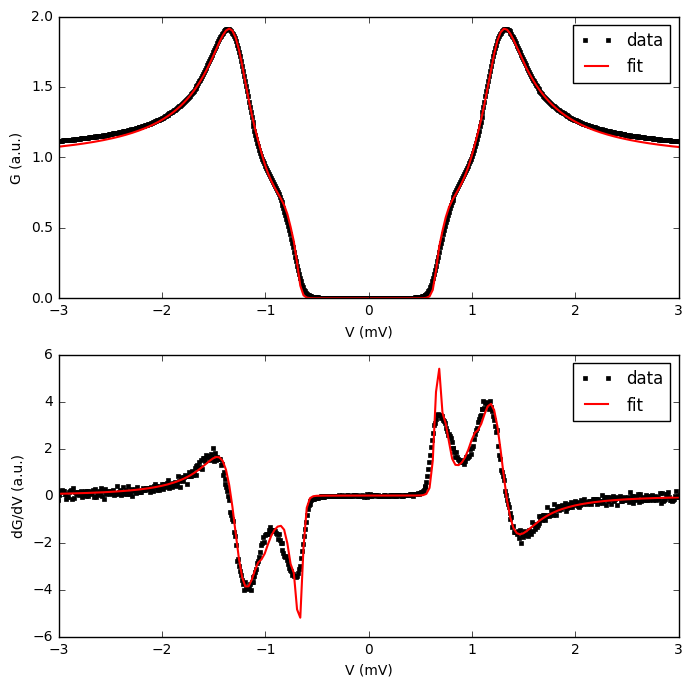

In [10]:
V, G, Gasym = LoadandSymmetrizeTemp(1,0.12)
Gerr = abs(Gasym)+0.02
params = makeParamaters([1.24,0.4,0.4,1.24,1,0.1,0.016])
params['T'].vary = False  
start = time.time()
out = minimize(Goodness, params, args=(V, G, Gerr,[-1.5,1.5]))
end = time.time()

FitFixedT200mK = readParameters(out.params)
FitFixedT200mKRaw = out



print(fit_report(out))
fig = LoadFitPlot(V,G,out.params,[-3,3])

## Perpendicular field analysis

Here are 2D maps of the conductance and its derivative as a function of bias and field. The second peak can be seen to diminish significantly above 10 mT.

In [ ]:
k = 1
Vs, Gs, Gasym = LoadandSymmetrizePerField(1,-0.035)
dGdVs = numpy.diff(G)/numpy.diff(V)
Bs = numpy.ones(len(V))*4*(15-(k-1)/3)

for k in range(2,47):
    V, G, Gasym = LoadandSymmetrizePerField(k,-0.035)
    dGdV = numpy.diff(G)/numpy.diff(V)
    B = numpy.ones(len(V))*4*(15-(k-1)/3)
    
    Vs = numpy.vstack((Vs, V))
    Gs = numpy.vstack((Gs, G))   
    dGdVs = numpy.vstack((dGdVs, dGdV))
    Bs = numpy.vstack((Bs, B))
    
PerB = Bs.transpose()[0]

In [ ]:
plt.subplot(1,2,1)
plt.pcolor(Bs,Vs,Gs,cmap = 'RdBu')
plt.ylim([-3,3])
plt.xlabel('$B_\perp$ (mT)')
plt.ylabel('V (mV)')
plt.title('$dI/dV$ Vs $B_\perp$')

plt.subplot(1,2,2)
plt.pcolor((Bs.transpose())[:][0:Vs.shape[1]-1],(Vs.transpose())[:][0:Vs.shape[1]-1],numpy.log(abs(dGdVs.transpose())),\
          cmap='RdBu')
plt.ylim([-3,3])
plt.xlabel('$B_\perp$ (mT)')
plt.ylabel('V (mV)')
plt.title('$d^2I/dV^2$ Vs $B_\perp$')

In [ ]:
X = Vs
Y = Bs
Z = Gs



fig = plt.figure()
ax = fig.gca(projection='3d')               # 3d axes instance
surf = ax.plot_surface(X, Y, Z,             # data values (2D Arryas)
                       rstride=1,           # row step size
                       cstride=3,           # column step size
                       cmap=cm.RdBu,        # colour map
                       linewidth=0.1,         # wireframe line width
                       antialiased=True)

ax.zaxis.set_major_locator(LinearLocator(5))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# ax.set_title('Conudctance curves as a function of parallel field')        # title
# fig.colorbar(surf, shrink=0.5, aspect=5)     # colour bar

ax.view_init(elev=30,azim=90)                # elevation & angle
ax.dist=8                                    # distance from the plot
plt.show()

X = (Vs.transpose())[:][0:Vs.shape[1]-1]
Y = (Bs.transpose())[:][0:Vs.shape[1]-1]
Z = abs(dGdVs.transpose())

fig = plt.figure()
ax = fig.gca(projection='3d')               # 3d axes instance
surf = ax.plot_surface(X, Y, Z,             # data values (2D Arryas)
                       rstride=1,           # row step size
                       cstride=3,           # column step size
                       cmap=cm.RdBu,        # colour map
                       linewidth=0.1,         # wireframe line width
                       antialiased=True)

ax.zaxis.set_major_locator(LinearLocator(5))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# ax.set_title('Conudctance curves as a function of parallel field')        # title
# fig.colorbar(surf, shrink=0.5, aspect=5)     # colour bar

ax.view_init(elev=30,azim=90)                # elevation & angle
ax.dist=8                                    # distance from the plot
plt.show()

In [ ]:
bigdata = scipy.io.loadmat('summary-data.mat')
G0 = bigdata['CondPerpField'][0][0][0][0][0][0]
plt.xlabel('B (mT)')
plt.ylabel('zero bias conductance ($\mu$S)')
plt.plot(PerB,G0,color = 'black',linewidth = 0,marker = 's')
plt.show()

### V shape fits

Here make linear fits to the bottom of the curves. The linear fit is given by: $N(V) = N_0 (H) + \alpha |V - V_0| $. Below are show $\alpha$, $N_0$ and $V_0$ as a function of field. There is a clear linear trend for the latter two. 
Below a few example of the linear fit are shown. The is shape is not perfectly V, however it is not the U shpae obtained at low fields.

In [32]:
for k in range(1,47):             
    V, G, Gasym = LoadandSymmetrizePerField(k,-0.035)
    Gerr = 0*abs(Gasym)+0.01
    params = makeVParamaters([0.01,1,1,0])
    params['a'].vary = True
    out = minimize(VortexFit, params, args=(V, G, Gerr,[-0.2,0.2]))
    if k == 1:
        PerFieldLinFit = readVParameters(out.params)
    else:       
        PerFieldLinFit = numpy.vstack((PerFieldLinFit,readVParameters(out.params)))

PerFieldLinFit_0p2 = PerFieldLinFit

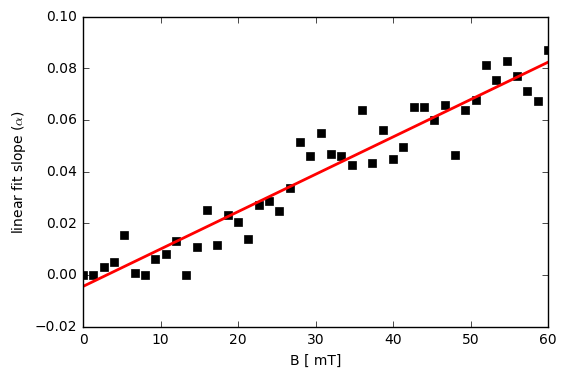

ValueError: x and y must have same first dimension

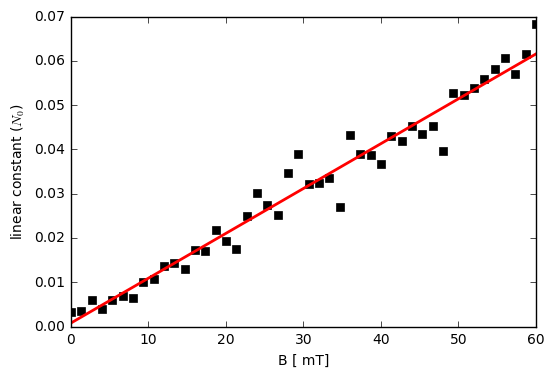

In [28]:
plt.plot(PerB,(PerFieldLinFit.transpose())[1],color = 'black',label = 'data',marker = 's',\
             markersize = 6,linewidth = 0)
linfit = numpy.polyfit(PerB,(PerFieldLinFit.transpose())[1],1)
plt.plot(PerB,linfit[0]*PerB + linfit[1],color = 'red',linewidth = 2)
plt.xlabel('B [ mT]') 
plt.ylabel('linear fit slope ($ \\alpha $)')
plt.show()


plt.plot(PerB,(PerFieldLinFit.transpose())[2],color = 'black',label = 'data',marker = 's',\
             markersize = 6,linewidth = 0)
linfit = numpy.polyfit(PerB,(PerFieldLinFit.transpose())[2],1)
plt.plot(PerB,linfit[0]*PerB + linfit[1],color = 'red',linewidth = 2)
plt.xlabel('B [ mT]') 
plt.ylabel('linear constant ($ N_0 $)')
plt.plot(PerB,G0/7,color = 'green',label = 'data',marker = 's',\
             markersize = 6,linewidth = 0)
plt.show()

plt.plot(PerB,(PerFieldLinFit.transpose())[3],color = 'black',label = 'data',marker = 's',\
             markersize = 6,linewidth = 0)
plt.xlabel('B [ mT]') 
plt.ylabel('zero bias correction ($V_0$)')
plt.show()

plt.plot(PerB,(PerFieldLinFit.transpose())[0],color = 'black',label = 'data',marker = 's',\
             markersize = 6,linewidth = 0)
plt.xlabel('B [ mT]') 
plt.ylabel('square coeff')
plt.show()

for k in range(1,46,4):
    print('B = ',PerB[k-1],'mT')
    V, G, Gasym = LoadandSymmetrizePerField(k,-0.035)

    MinIndex = numpy.argmin(abs(V+0.4))
    MaxIndex = numpy.argmin(abs(V-0.4))
    V = V[MinIndex:MaxIndex]
    G = G[MinIndex:MaxIndex]
    a = PerFieldLinFit[k-1][0]
    b = PerFieldLinFit[k-1][1]
    c = PerFieldLinFit[k-1][2]
    V0 = PerFieldLinFit[k-1][3]
    plt.plot(V,G,color = 'black',label = 'data',marker = 's',\
                 markersize = 6,linewidth = 0)
    plt.plot(V,a*(V-V0)**2+b*abs((V-V0))+c,color = 'red',linewidth = 2)
    plt.show()



## Fit of the McMillen to curves with fields

Attempting tp compare between different gfit methods - either to G or to dG/dV. Done at 35mT. Fitting to dG/dV seems nicer.

In [ ]:
V, G, Gasym = LoadandSymmetrizePerField(19,-0.035)
params = makeParamaters([1.21,0.164,0.2,1.25,1,0.11,1.3*0.08])
fig = LoadFitPlot(V,G,params,[-3,3])

out1 = minimize(Goodness, params, args = (V,G,0.02*numpy.ones(len(V)),[0.5,1.3]))
out2 = minimize(Goodness, params, args=(V, G, Gerr,[0.5,1.3]),method='Nelder')
out3 = minimize(Goodness2, params, args = (V,G,0.02*numpy.ones(len(V)),[0.5,1.3]))
out4 = minimize(Goodness2, params, args=(V, G, Gerr,[0.5,1.3]),method='Nelder')

In [ ]:
V, G, Gasym = LoadandSymmetrizePerField(19,-0.035)

print('Fitting according to G, default method')
print(fit_report(out1))
fig = LoadFitPlot(V,G,out1.params,[-3,3])
# print('Fitting according to G, Nelder method')
# print(fit_report(out2))
# fig = LoadFitPlot(V,G,out2.params,[-3,3])
print('Fitting according to dG/dV, Default method')
print(fit_report(out3))
fig = LoadFitPlot(V,G,out3.params,[-3,3])
# print('Fitting according to dG/dV, Nelder method')
# print(fit_report(out4))
# fig = LoadFitPlot(V,G,out4.params,[-3,3])



Using the the second derivative as the selected method for calculating the fit, below we see the results of fitting the entire field range. In this fit $\Delta_1$ and $\Delta_2$ were kept fixed. In the zero field $N_\text{eff2}$ was allowd to change and then kept also fixed. First we see the results of the compilation and then the fits themselves.

In [ ]:
k = 46
V, G, Gasym = LoadandSymmetrizePerField(0,-0.035)
Gerr = 0.02*numpy.ones(len(V));
params = makeParamaters([1.206,0.385,0.05,0.67,1,0.2,0.12])
params['Delta01'].vary = False
params['Delta02'].vary = False
# fig = LoadFitPlot(V,G,params,[-3,3])

start = time.time()
out = minimize(Goodness2, params, args = (V,G,Gerr,[0.5,1.3]))
print(k,': ',time.time() - start)

PerFieldData = readParameters(out.params)
PerFielddataRaw = [out]
for k in range(45,0,-1):
    params = out.params
    params['Neff2'].vary = False             
    V, G, Gasym = LoadandSymmetrizePerField(k,-0.035)
    start = time.time()
    out = minimize(Goodness2, params, args=(V, G, Gerr,[0.5,1.3]))
    end = time.time()
    print(k,': ',time.time() - start)
    PerFieldData = numpy.vstack((PerFieldData,readParameters(out.params)))
    PerFielddataRaw.append(out)

In [ ]:
plt.plot(PerB,(numpy.flipud(PerFieldData).transpose())[2],color = 'black',label = 'data',marker = 's',\
             markersize = 6,linewidth = 0)
plt.xlabel('B [ mT]') 
plt.ylabel('$\Gamma_1$ (eV)')
plt.show()

plt.plot(PerB,(numpy.flipud(PerFieldData).transpose())[3],color = 'black',label = 'data',marker = 's',\
             markersize = 6,linewidth = 0)
plt.xlabel('B [ mT]') 
plt.ylabel('$\Gamma_2$ (eV)')
plt.show()

plt.plot(PerB,(numpy.flipud(PerFieldData).transpose())[6]/0.08,color = 'black',label = 'data',marker = 's',\
             markersize = 6,linewidth = 0)
plt.xlabel('B [ mT]') 
plt.ylabel('$T_\text{fit$ (K)}')
plt.show()

for k in range(46,0,-4):
    print('B = ',PerB[k-1])
    temp = numpy.flipud(PerFieldData)
    V, G, Gasym = LoadandSymmetrizePerField(k,-0.035)
    fig = LoadFitPlot(V,G,makeParamaters(temp[k-1]),[-3,3])

For comparison I show the fittings when alll of the free parameters except $N_\text{eff2}$ are free:

In [ ]:
plt.plot(PerB,(numpy.flipud(PerFieldDataFreeDeltas).transpose())[0],color = 'black',label = 'data',marker = 's',\
             markersize = 6,linewidth = 0)
plt.xlabel('B [ mT]') 
plt.ylabel('$\Delta_1$ (eV)')
plt.show()

plt.plot(PerB,(numpy.flipud(PerFieldDataFreeDeltas).transpose())[1],color = 'black',label = 'data',marker = 's',\
             markersize = 6,linewidth = 0)
plt.xlabel('B [ mT]') 
plt.ylabel('$\Delta_2$ (eV)')
plt.show()

plt.plot(PerB,(numpy.flipud(PerFieldDataFreeDeltas).transpose())[2],color = 'black',label = 'data',marker = 's',\
             markersize = 6,linewidth = 0)
plt.xlabel('B [ mT]') 
plt.ylabel('$\Gamma_1$ (eV)')
plt.show()

plt.plot(PerB,(numpy.flipud(PerFieldDataFreeDeltas).transpose())[3],color = 'black',label = 'data',marker = 's',\
             markersize = 6,linewidth = 0)
plt.xlabel('B [ mT]') 
plt.ylabel('$\Gamma_2$ (eV)')
plt.show()

plt.plot(PerB,(numpy.flipud(PerFieldDataFreeDeltas).transpose())[6]/0.08,color = 'black',label = 'data',marker = 's',\
             markersize = 6,linewidth = 0)
plt.xlabel('B [ mT]') 
plt.ylabel('$T_\text{fit$ (K)}')
plt.show()

for k in range(46,0,-4):
    print('B = ',PerB[k-1])
    temp = numpy.flipud(PerFieldDataFreeDeltas)
    V, G, Gasym = LoadandSymmetrizePerField(k,-0.035)
    fig = LoadFitPlot(V,G,makeParamaters(temp[k-1]),[-3,3])

Now keeping $\Gamma$ fixed and allowing only $\Delta$ to change. It is not possible obtain a good fit.

In [ ]:
k = 46
V, G, Gasym = LoadandSymmetrizePerField(0,-0.035)
Gerr = 0.02*numpy.ones(len(V));
params = makeParamaters([1.206,0.385,0.05,0.67,1,0.2,0.12])
# fig = LoadFitPlot(V,G,params,[-3,3])

start = time.time()
out = minimize(Goodness2, params, args = (V,G,Gerr,[0.5,1.3]))
print(k,': ',time.time() - start)

PerFieldDataFixedGammas = readParameters(out.params)
PerFielddataFixedGammasRaw = [out]
for k in range(45,0,-1):
    params = out.params
    params['Neff2'].vary = False 
    params['Gamma1'].vary = False 
    params['Gamma2'].vary = False 
    V, G, Gasym = LoadandSymmetrizePerField(k,-0.035)
    start = time.time()
    out = minimize(Goodness2, params, args=(V, G, Gerr,[0.5,1.3]))
    end = time.time()
    print(k,': ',time.time() - start)
    PerFieldDataFixedGammas = numpy.vstack((PerFieldDataFixedGammas,readParameters(out.params)))
    PerFielddataFixedGammasRaw.append(out)

In [ ]:
plt.plot(PerB,(numpy.flipud(PerFieldDataFixedGammas).transpose())[0],color = 'black',label = 'data',marker = 's',\
             markersize = 6,linewidth = 0)
plt.xlabel('B [ mT]') 
plt.ylabel('$\Delta_1$ (eV)')
plt.show()

plt.plot(PerB,(numpy.flipud(PerFieldDataFixedGammas).transpose())[1],color = 'black',label = 'data',marker = 's',\
             markersize = 6,linewidth = 0)
plt.xlabel('B [ mT]') 
plt.ylabel('$\Delta_2$ (eV)')
plt.show()

plt.plot(PerB,(numpy.flipud(PerFieldDataFixedGammas).transpose())[2],color = 'black',label = 'data',marker = 's',\
             markersize = 6,linewidth = 0)
plt.xlabel('B [ mT]') 
plt.ylabel('$\Gamma_1$ (eV)')
plt.show()

plt.plot(PerB,(numpy.flipud(PerFieldDataFixedGammas).transpose())[3],color = 'black',label = 'data',marker = 's',\
             markersize = 6,linewidth = 0)
plt.xlabel('B [ mT]') 
plt.ylabel('$\Gamma_2$ (eV)')
plt.show()

plt.plot(PerB,(numpy.flipud(PerFieldDataFixedGammas).transpose())[6]/0.08,color = 'black',label = 'data',marker = 's',\
             markersize = 6,linewidth = 0)
plt.xlabel('B [ mT]') 
plt.ylabel('$T_\text{fit$ (K)}')
plt.show()

for k in range(46,0,-4):
    print('B = ',PerB[k-1])
    temp = numpy.flipud(PerFieldDataFixedGammas)
    V, G, Gasym = LoadandSymmetrizePerField(k,-0.035)
    fig = LoadFitPlot(V,G,makeParamaters(temp[k-1]),[-3,3])



## Parallel field analysis


In [14]:
k = 1
Vs, Gs, Gasym,B = LoadandSymmetrizeParField(1,-0.035)
V = Vs
G = Gs
dGdVs = numpy.diff(G)/numpy.diff(V)
Bs = numpy.ones(len(V))*B

for k in range(2,35):
    V, G, Gasym, B = LoadandSymmetrizeParField(k,-0.035)
    dGdV = numpy.diff(G)/numpy.diff(V)
    
    Vs = numpy.vstack((Vs, V))
    Gs = numpy.vstack((Gs, G))   
    dGdVs = numpy.vstack((dGdVs, dGdV))
    Bs = numpy.vstack((Bs, numpy.ones(len(V))*B))
    
ParB = Bs.transpose()[0]

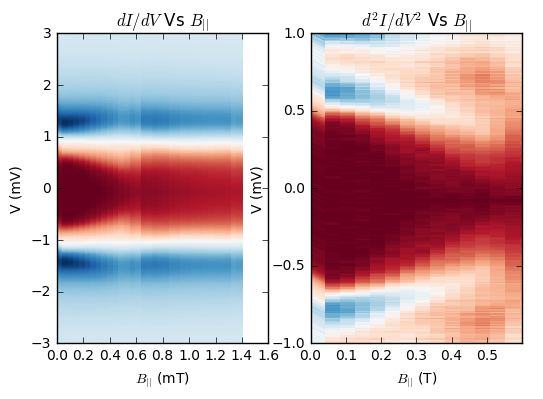

In [16]:
plt.subplot(1,2,1)
plt.pcolor(Bs,Vs,Gs,cmap = 'RdBu')
plt.ylim([-3,3])
plt.xlabel('$B_{||}$ (mT)')
plt.ylabel('V (mV)')
plt.title('$dI/dV$ Vs $B_{||}$')

plt.subplot(1,2,2)
plt.pcolor((Bs.transpose())[:][0:Vs.shape[1]-1],(Vs.transpose())[:][0:Vs.shape[1]-1],(abs(dGdVs.transpose())),\
          cmap='RdBu')
plt.ylim([-1,1])
plt.xlim([0,0.6])
plt.xlabel('$B_{||}$ (T)')
plt.ylabel('V (mV)')
plt.title('$d^2I/dV^2$ Vs $B_{||}$')

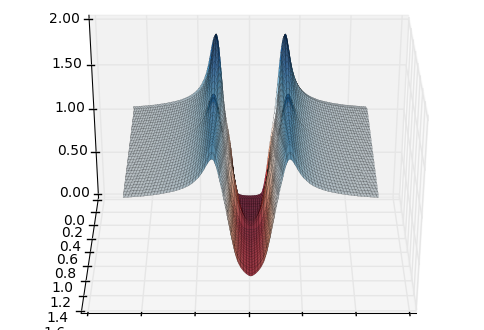

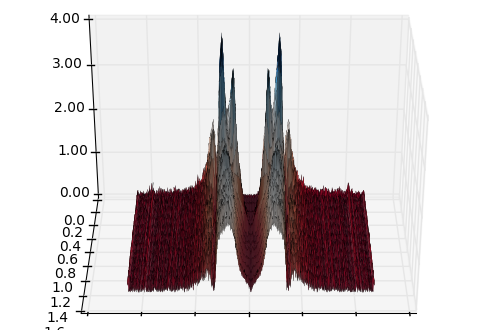

In [17]:
X = Vs
Y = Bs
Z = Gs



fig = plt.figure()
ax = fig.gca(projection='3d')               # 3d axes instance
surf = ax.plot_surface(X, Y, Z,             # data values (2D Arryas)
                       rstride=1,           # row step size
                       cstride=3,           # column step size
                       cmap=cm.RdBu,        # colour map
                       linewidth=0.1,         # wireframe line width
                       antialiased=True)

ax.zaxis.set_major_locator(LinearLocator(5))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# ax.set_title('Conudctance curves as a function of parallel field')        # title
# fig.colorbar(surf, shrink=0.5, aspect=5)     # colour bar

ax.view_init(elev=30,azim=90)                # elevation & angle
ax.dist=8                                    # distance from the plot
plt.show()

X = (Vs.transpose())[:][0:Vs.shape[1]-1]
Y = (Bs.transpose())[:][0:Vs.shape[1]-1]
Z = abs(dGdVs.transpose())

fig = plt.figure()
ax = fig.gca(projection='3d')               # 3d axes instance
surf = ax.plot_surface(X, Y, Z,             # data values (2D Arryas)
                       rstride=1,           # row step size
                       cstride=3,           # column step size
                       cmap=cm.RdBu,        # colour map
                       linewidth=0.1,         # wireframe line width
                       antialiased=True)

ax.zaxis.set_major_locator(LinearLocator(5))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# ax.set_title('Conudctance curves as a function of parallel field')        # title
# fig.colorbar(surf, shrink=0.5, aspect=5)     # colour bar

ax.view_init(elev=30,azim=90)                # elevation & angle
ax.dist=8                                    # distance from the plot
plt.show()

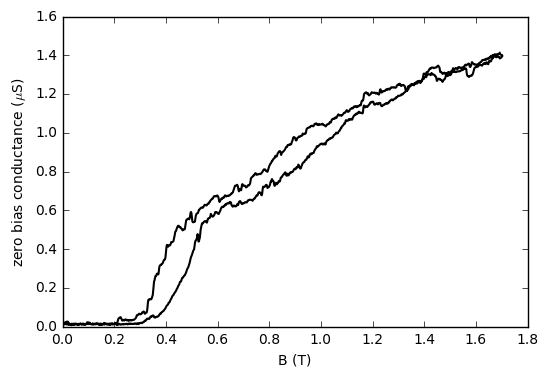

In [18]:
bigdata = scipy.io.loadmat('summary-data.mat')
data = bigdata['CondParField'][0][0][0][0][0][0].transpose()
B = data[1]
G0 = data[2]
plt.xlabel('B (T)')
plt.ylabel('zero bias conductance ($\mu$S)')
plt.plot(B,G0,color = 'black',linewidth = 1.5)
plt.show()

In [ ]:
k = 5
print("%.2f" % ParB[k-1])
V, G, Gasym,B = LoadandSymmetrizeParField(k,0.025)
Gerr= 0*Gasym + 0.02
params = makeParamaters([1.21,0.1,0.4,1.5,1,0.1,0.23])
params['Neff2'].vary = False
out = minimize(Goodness, params, args=(V, G, Gerr,[0.3,1.5]))
fig = LoadFitPlot(V,G,out.params,[-3,3])
print(fit_report(out))

In [33]:
for k in range(1,35):             
    V, G, Gasym, B = LoadandSymmetrizeParField(k,0.025)
    Gerr = 0*abs(Gasym)+0.01
    params =  makeVParamaters([0.01,1,1,0])
    params['a'].vary = True
    out = minimize(VortexFit,params, args=(V, G, Gerr,[-0.2,0.2]))
    if k == 1:
        ParFieldLinFit = readVParameters(out.params)
    else:       
        ParFieldLinFit = numpy.vstack((ParFieldLinFit,readVParameters(out.params)))

ParFieldLinFit_0p2 = ParFieldLinFit

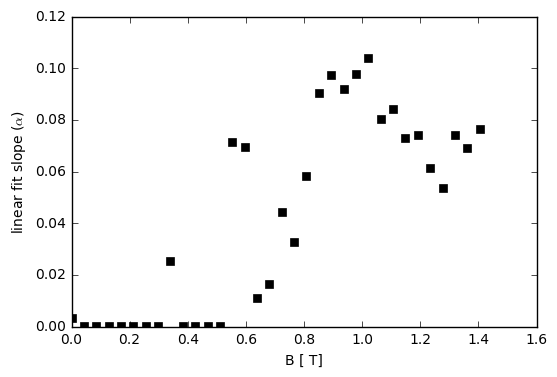

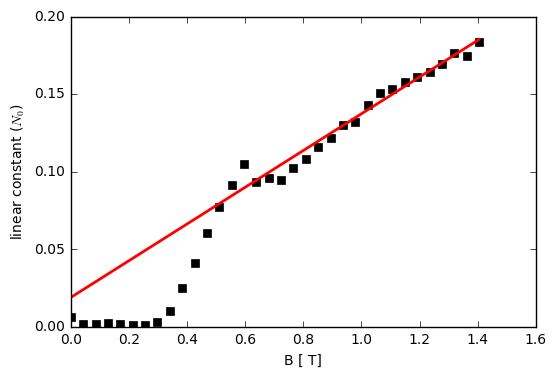

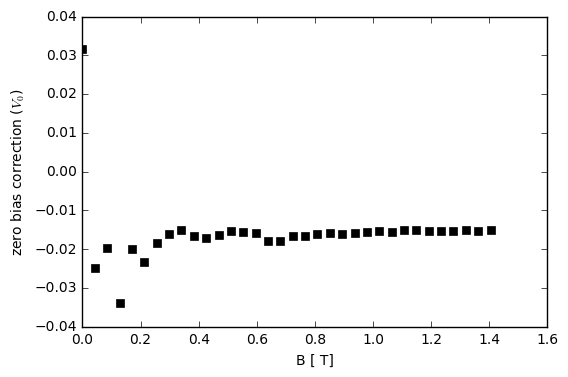

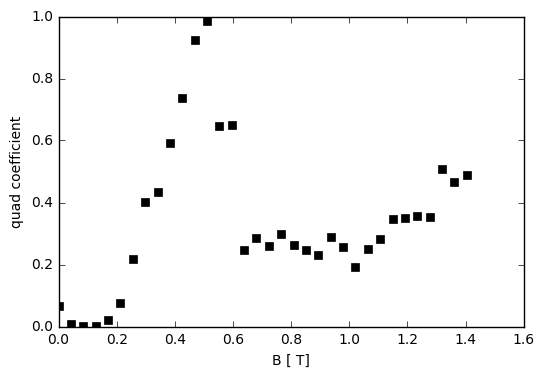

B =  0.0 T


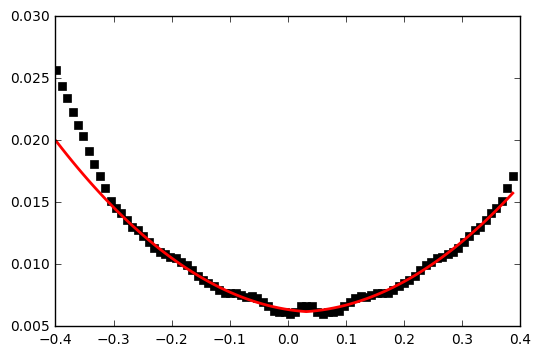

B =  0.170212765957 T


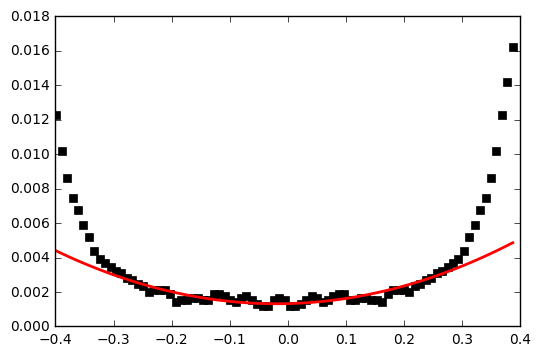

B =  0.340425531915 T


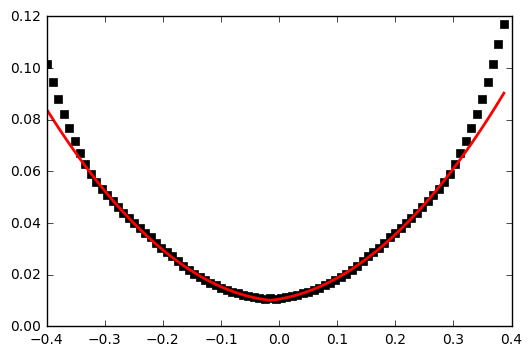

B =  0.510638297872 T


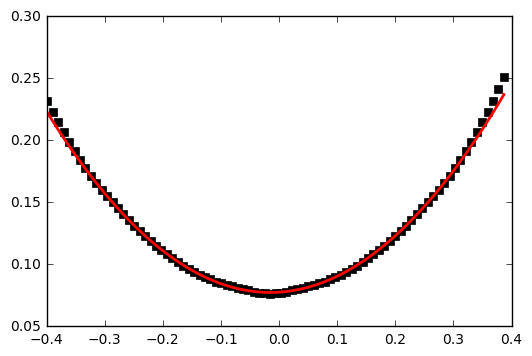

B =  0.68085106383 T


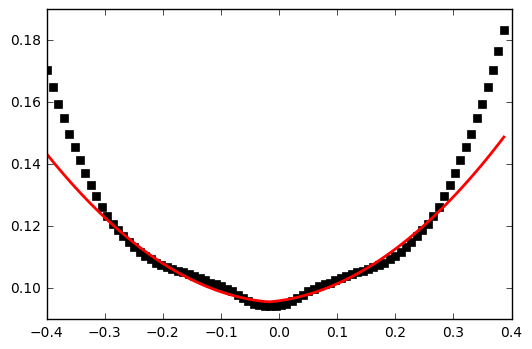

B =  0.851063829787 T


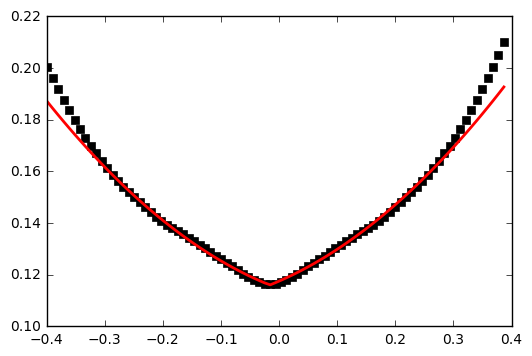

B =  1.02127659574 T


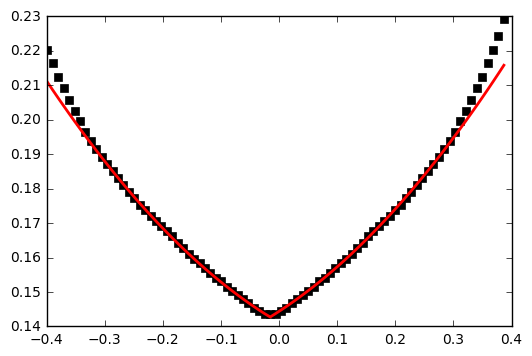

B =  1.1914893617 T


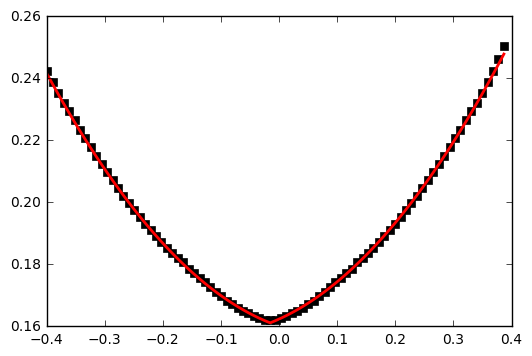

B =  1.36170212766 T


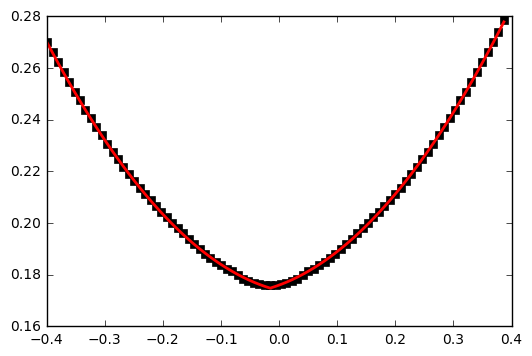

In [25]:
plt.plot(ParB,(ParFieldLinFit.transpose())[1],color = 'black',label = 'data',marker = 's',\
             markersize = 6,linewidth = 0)
linfit = numpy.polyfit(ParB[20:34],(ParFieldLinFit.transpose())[1][20:34],1)
# plt.plot(ParB,linfit[0]*ParB + linfit[1],color = 'red',linewidth = 2)
plt.xlabel('B [ T]') 
plt.ylabel('linear fit slope ($ \\alpha $)')
plt.show()


plt.plot(ParB,(ParFieldLinFit.transpose())[2],color = 'black',label = 'data',marker = 's',\
             markersize = 6,linewidth = 0)
linfit = numpy.polyfit(ParB[20:34],(ParFieldLinFit.transpose())[2][20:34],1)
plt.plot(ParB,linfit[0]*ParB + linfit[1],color = 'red',linewidth = 2)
plt.xlabel('B [ T]') 
plt.ylabel('linear constant ($ N_0 $)')
plt.show()

plt.plot(ParB,(ParFieldLinFit.transpose())[3],color = 'black',label = 'data',marker = 's',\
             markersize = 6,linewidth = 0)
plt.xlabel('B [ T]') 
plt.ylabel('zero bias correction ($V_0$)')
plt.show()

plt.plot(ParB,(ParFieldLinFit.transpose())[0],color = 'black',label = 'data',marker = 's',\
             markersize = 6,linewidth = 0)
plt.xlabel('B [ T]') 
plt.ylabel('quad coefficient')
plt.show()

for k in range(1,34,4):
    print('B = ',ParB[k-1],'T')
    V, G, Gasym, B = LoadandSymmetrizeParField(k,0.025)
    MinIndex = numpy.argmin(abs(V+0.4))
    MaxIndex = numpy.argmin(abs(V-0.4))
    V = V[MinIndex:MaxIndex]
    G = G[MinIndex:MaxIndex]
    a = ParFieldLinFit[k-1][0]
    b = ParFieldLinFit[k-1][1]
    c = ParFieldLinFit[k-1][2]
    V0 = ParFieldLinFit[k-1][3]
    plt.plot(V,G,color = 'black',label = 'data',marker = 's',\
                 markersize = 6,linewidth = 0)
    plt.plot(V,a*(V-V0)**2+b*abs((V-V0))+c,color = 'red',linewidth = 2)
    plt.show()

## sub-gap signal in parallel fields

In [ ]:
Vs, Bs, Gs, Vsm1, Bsm1, dGdVs, ParB = LoadAllParField(0,False)

In [13]:
Gerr = numpy.ones(Bs.shape[1])
for k in range(0,Bs.shape[0]):             
    params = makeVParamaters([0.01,1,1,0])
    params['a'].vary = True
    out = minimize(VortexFit, params, args=(Vs[k], Gs[k], Gerr,[-0.4,0.2]))
    if k == 0:
        ParFieldLinFit = readVParameters(out.params)
    else:       
        ParFieldLinFit = numpy.vstack((ParFieldLinFit,readVParameters(out.params)))

NameError: name 'Bs' is not defined

In [ ]:
plt.subplot(1,2,1)
plt.pcolor(Bs,Vs,Gs,cmap = 'RdBu')
plt.ylim([-3,3])
plt.xlabel('$B_{||}$ (mT)')
plt.ylabel('V (mV)')
plt.title('$dI/dV$ Vs $B_{||}$')

plt.subplot(1,2,2)
plt.pcolor(Bsm1,Vsm1,numpy.log(abs(dGdVs)), cmap='RdBu', vmin = -2, vmax = 3)
plt.ylim([-3,3])
# plt.xlim([0,0.6])
plt.xlabel('$B_{||}$ (T)')
plt.ylabel('V (mV)')
plt.title('$d^2I/dV^2$ Vs $B_{||}$')

In [ ]:
plt.plot(Vsm1[0],numpy.log(abs(dGdVs[5])))

In [ ]:
k = 33
MinIndex = numpy.argmin(abs(Vs[k]+0.6))
MaxIndex = numpy.argmin(abs(Vs[k]-0.6))
Vtemp = Vs[k][MinIndex:MaxIndex]
Gtemp = Gs[k][MinIndex:MaxIndex]
plt.plot(Vtemp,Gtemp,'s')
plt.plot(Vtemp,GiveGs(Vtemp,ParFieldLinFit[k]),linewidth = 2)

In [ ]:
for k in range(0,Bs.shape[0]):
    MinIndex = numpy.argmin(abs(Vs[k]+1.5))
    MaxIndex = numpy.argmin(abs(Vs[k]-0.1))
    Vtemp = Vs[k][MinIndex:MaxIndex]
    Gtemp = Gs[k][MinIndex:MaxIndex]
    Btemp = Bs[k][MinIndex:MaxIndex-1]
    Vtempm1 = Vtemp[0:len(Vtemp)-1]
    dGdVmBg = numpy.diff(Gtemp-GiveGs(Vtemp,ParFieldLinFit[k]))/numpy.diff(Vtemp)
    if k == 0:
        Vsm1New = Vtempm1
        dGdVsNew = dGdVmBg
        Bsm1New = Btemp
    else:
        Vsm1New = numpy.vstack((Vsm1New,Vtempm1))
        dGdVsNew = numpy.vstack((dGdVsNew,dGdVmBg))
        Bsm1New = numpy.vstack((Bsm1New,Btemp))